In [1]:
import torch
import glob
import os
from PIL import Image
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.preprocessing import normalize
import keras
from keras.utils import normalize, to_categorical
from sklearn.preprocessing import LabelEncoder
import segmentation_models as sm
from torch.utils.data import DataLoader
import albumentations as album

Segmentation Models: using `keras` framework.


In [35]:
import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, test = False):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','*.png'))
        self.mask_files = []
        self.img = []
        self.mask = []
        self.test = test
        
        if not self.test:
            for img_path in self.img_files:
                self.mask_files.append(os.path.join(folder_path,'labels',os.path.basename(img_path.split(".")[0] + "_Annotation.png"))) 
        

    def __getall__(self):
        for each in self.img_files:
            self.img.append(normalize(cv2.resize(cv2.imread(each, cv2.IMREAD_COLOR), (512,512)), axis = 1))
        if not self.test:
            for each in self.mask_files:
                self.mask.append(cv2.resize(cv2.imread(each, 0), (512,512)))
            return (np.array(self.img)) , (np.array(self.mask))
        else:
            return (np.array(self.img))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_COLOR)
            label = cv2.imread(mask_path, 0)
            label = to_categorical(label, 6)
            return torch.from_numpy(data).float().permute(2,0,1), torch.from_numpy(label).float().permute(2,0,1)

    def __len__(self):
        return len(self.img_files)

In [36]:
train_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\train")
val_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\val")
test_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\test", test = True)

torch.Size([3, 540, 800]) torch.Size([6, 540, 800])
torch.Size([540, 800, 3])


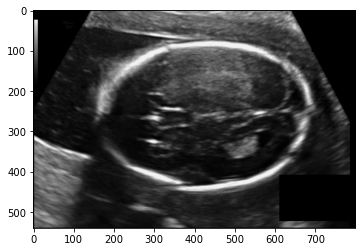

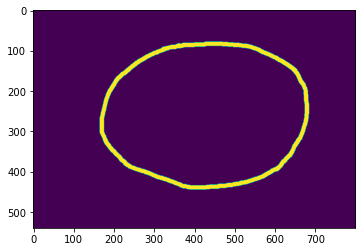

In [37]:
image, mask = train_dataset.__getitem__(5)
print(image.shape, mask.shape)
print(image.permute(1, 2, 0).shape)
plt.imshow(image.permute(1, 2, 0)/255)
plt.show()
plt.imshow(mask[1]/255)
plt.show()

In [38]:
train_images, train_masks = train_dataset.__getall__()
val_images, val_masks = val_dataset.__getall__()
test_images = test_dataset.__getall__()

In [39]:
print(train_images.shape, train_masks.shape)
print(val_images.shape, val_masks.shape)
print(test_images.shape)

(59, 512, 512, 3) (59, 512, 512)
(10, 512, 512, 3) (10, 512, 512)
(13, 512, 512, 3)


In [40]:
print(np.unique(train_masks))

[0 1 2 3 4 5]


In [41]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [42]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Class weights are...: [ 0.27363086  3.49018015 19.8645973  28.50893433 16.00420529  0.52328018]


In [43]:
train_masks_cat = (to_categorical(train_masks, num_classes = 6))
val_masks_cat = (to_categorical(val_masks, num_classes = 6))
print(train_masks_cat.shape)
print(val_masks_cat.shape)

(59, 512, 512, 6)
(10, 512, 512, 6)


In [44]:
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = False)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = False)

In [45]:
# def expanddims_n_tocategorical(x):
#     #x = x.unsqueeze(1)
#     x = torch.from_numpy(to_categorical(x.detach().numpy(), num_classes= 6))
#     return x.permute(0,3,1,2)

torch.Size([1, 3, 540, 800]) torch.Size([1, 6, 540, 800])


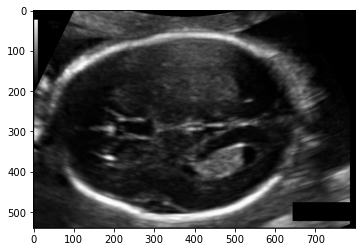

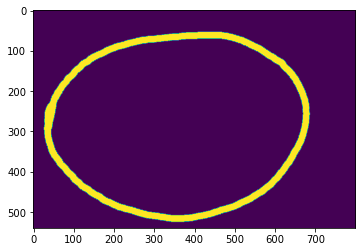

In [46]:
images, labels = next(iter(train_dataloader))
#labels = expanddims_n_tocategorical(labels)
print(images.shape, labels.shape)
#print(images[0].permute(1,2,0).shape)
plt.imshow(images[0].permute(1,2,0)/255)
plt.show()
plt.imshow(labels[0][1]/255)
plt.show()

# Model

In [47]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

# Setup

In [48]:
n_classes=6
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights = class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [51]:
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]
print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(train_images, 
                    train_masks_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(val_images, val_masks_cat), 
                    #class_weight=class_weights,
                    shuffle=False)

512 512 3
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 512, 512, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 512, 512, 16) 0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 512, 512, 16) 2320        dropout_23[0][0]                 
____________________________________________________________________________

In [ ]:
y_pred=model.predict(val_images)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

In [30]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(train_images)
X_val = preprocess_input1(val_images)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())


Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_68 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_68[0][0]          
______________________________________________________________________________________

In [32]:
history1=model1.fit(X_train1, 
          train_masks_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_val, val_masks_cat))

Epoch 1/50


ValueError: in user code:

    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\layers\merge.py:183 call
        return self._merge_function(inputs)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\layers\merge.py:522 _merge_function
        return K.concatenate(inputs, axis=self.axis)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\keras\backend.py:2881 concatenate
        return array_ops.concat([to_dense(x) for x in tensors], axis)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\ops\array_ops.py:1654 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:1220 concat_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimension 1 in both shapes must be equal, but are 136 and 135. Shapes are [?,136,200] and [?,135,200]. for '{{node functional_11/decoder_stage2_concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](functional_11/decoder_stage2_upsampling/resize/ResizeNearestNeighbor, functional_11/stage2_unit1_relu1/Relu, functional_11/decoder_stage2_concat/concat/axis)' with input shapes: [?,136,200,128], [?,135,200,64], [] and with computed input tensors: input[2] = <3>.
